# Group Assignment 1

## Group Members
* S Ramaneesen
* Mishra Aviral

Both of us contributed equally

## Installing Dependencies

In [1]:
!pip install gym
!pip install matplotlib
!pip install torch
!pip install pygame
!pip install moviepy
!pip install gym[classic_control]


  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [1 lines of output]
  ERROR: Can not execute `setup.py` since setuptools is not available in the build environment.
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Importing Dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import os
from collections import deque
from IPython.display import HTML
from IPython import display as ipythondisplay

# Function to show the video recorded
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data=f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{encoded.decode("ascii")}" type="video/mp4"></video>'))
    else:
        print("Could not find video")

## Loading CartPole environment


In [3]:
env = gym.make('CartPole-v1')
print(env.action_space)

Discrete(2)


In [4]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [5]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([-0.03346672, -0.04993287,  0.02725768,  0.02624945], dtype=float32), {})


## Choosing RL Agent

We will compare 2 RL Agents to see which is the better. \
First, we will use the Q-Learning algorithm.

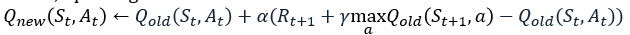

We will implement it using the formula taught in lecture for updating the Q-table. \
This equation represents how the agent learns to estimate the expected future rewards for each state-action pair. 
We use Q-Learning as it can train an agent to make optimal decisions in an environment by maximizing cumulative rewards. \

In the cartpole problem,  Q-Learning uses previously learnt states which have been explored to consider future moves and stores this information in a Q-Table.

## Setting parameters and Q-Table
We initialise and set the parameters below. We set the episodes to a higher value such as 50000 as the average reward is higher.

We also create the Q Table.
The Q-table is a multi-dimensional array storing action-value estimates for each state-action pair.


In [6]:
# parameters
ALPHA = 0.2  # learn rate
GAMMA = 1  # discount factor
EPISODES = 50000

# exploration parameters
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = (epsilon - epsilon_min) / 12500

# discretisation settings
STATE_BINS = [40, 40, 50, 50]  # num of bins per state variable
bin_widths = np.array([0.25, 0.25, 0.05, 0.5])  # bin size

# Q-table initialisation
q_table = np.zeros(tuple(STATE_BINS) + (env.action_space.n,))

In [7]:
# function to convert continuous states to discrete indices
def discretise_state(state):
    discrete_indices = (state / bin_widths + np.array([15, 10, 1, 10])).astype(int)
    return tuple(discrete_indices)

## Developing the RL Agent

The model starts with a fixed epsilon value (1.0), which represents the randomization of movements. Over time, the randomisation will decrease based upon the epsilon decay value that we set above. 

If the current state of the agent is seen to be unexplored, the agent will produce a randomly generated move to better learn the environment.

In [8]:
# Training function
def train_q_learning(env, episodes, alpha, gamma, epsilon, epsilon_decay, q_table):
    reward_history = []
    avg_reward = 0
    prev_avg_reward = 0
    
    for episode in range(episodes):
        state = discretise_state(env.reset()[0])
        done = False
        episode_reward = 0
        steps = 0
        
        if episode % 2000 == 0:
            print(f"Episode: {episode}")
        
        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() > epsilon:
                action = np.argmax(q_table[state])
            else:
                action = np.random.randint(env.action_space.n)
            
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretise_state(next_state)
            episode_reward += reward
            steps += 1
            
            # Modify reward based on performance
            if done:
                reward = 1 if steps >= 195 else -1
            else:
                reward = 0.1
            
            # Q-learning update rule
            best_future_q = np.max(q_table[next_state])
            q_table[state + (action,)] = (1 - alpha) * q_table[state + (action,)] + alpha * (reward + gamma * best_future_q)
            
            state = next_state
        
        reward_history.append(episode_reward)
        avg_reward += episode_reward
        
        # Adjust epsilon for exploration-exploitation balance
        if epsilon > epsilon_min and episode_reward > prev_avg_reward:
            epsilon -= epsilon_decay
        
        if episode % 1000 == 0:
            print(f"Epsilon: {epsilon:.4f}")
            print(f"Mean Reward (last 1000 episodes): {avg_reward / 1000:.2f}")
            prev_avg_reward = avg_reward / 1000
            avg_reward = 0
    
    env.close()
    return q_table, reward_history

# Train the agent
q_table, rewards = train_q_learning(env, EPISODES, ALPHA, GAMMA, epsilon, epsilon_decay, q_table)


Episode: 0
Epsilon: 0.9999
Mean Reward (last 1000 episodes): 0.05


C:\Users\Ram\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Epsilon: 0.9239
Mean Reward (last 1000 episodes): 22.76
Episode: 2000
Epsilon: 0.8858
Mean Reward (last 1000 episodes): 26.43
Epsilon: 0.8537
Mean Reward (last 1000 episodes): 28.01
Episode: 4000
Epsilon: 0.8226
Mean Reward (last 1000 episodes): 29.91
Epsilon: 0.7905
Mean Reward (last 1000 episodes): 32.31
Episode: 6000
Epsilon: 0.7566
Mean Reward (last 1000 episodes): 36.31
Epsilon: 0.7234
Mean Reward (last 1000 episodes): 38.55
Episode: 8000
Epsilon: 0.6889
Mean Reward (last 1000 episodes): 42.68
Epsilon: 0.6500
Mean Reward (last 1000 episodes): 48.85
Episode: 10000
Epsilon: 0.6113
Mean Reward (last 1000 episodes): 54.00
Epsilon: 0.5761
Mean Reward (last 1000 episodes): 55.68
Episode: 12000
Epsilon: 0.5362
Mean Reward (last 1000 episodes): 63.63
Epsilon: 0.4998
Mean Reward (last 1000 episodes): 67.62
Episode: 14000
Epsilon: 0.4578
Mean Reward (last 1000 episodes): 75.90
Epsilon: 0.4194
Mean Reward (last 1000 episodes): 82.04
Episode: 16000
Epsilon: 0.3774
Mean Reward (last 1000 episo

# Task 1 Sampling a random state from the cart pole environment
We sample a random state from the cart pole environment, inputting to the agent, and output a chosen action. 

In [9]:
def test_agent_action(env, q_table):
    
    state = env.reset()[0]
    
    print("Original Continuous State:", state)
    discrete_state = discretise_state(state)
    action = np.argmax(q_table[discrete_state])
    
    print("Chosen Action:", action)

test_agent_action(env, q_table)

Original Continuous State: [ 0.03449618 -0.00970023  0.00536554 -0.03947141]
Chosen Action: 0


# Task 2

Effectiveness of the RL Agent

In [10]:
def evaluate_agent(env, q_table, episodes=100):
    test_rewards = []
    
    for episode in range(episodes):
        state = discretise_state(env.reset()[0])
        done = False
        total_reward = 0
        
        while not done:
            action = np.argmax(q_table[state])
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            state = discretise_state(next_state)
            
            if total_reward > 500:
                done = True
        
        test_rewards.append(total_reward)
    
    env.close()
    return test_rewards

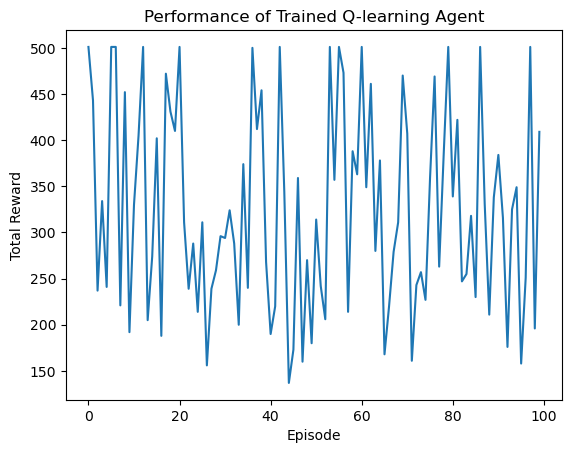

Average cumulative reward: 324.48
Is my agent good enough: True


In [11]:
# Run evaluation
eval_rewards = evaluate_agent(env, q_table)

# Plot results
plt.plot(eval_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance of Trained Q-learning Agent")
plt.show()

print(f"Average cumulative reward: {np.mean(eval_rewards):.2f}")
print(f"Is my agent good enough: {np.mean(eval_rewards) > 195}")


As shown in the graph, the Q-Learning Agent is good as its reward is higher than 195.

# Task 3 Rendering one episode played by the developed RL agent on Jupyter. 

In [12]:
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data=f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{encoded.decode("ascii")}" type="video/mp4"></video>'))
    else:
        print("Could not find video")

# Initialize environment with video recording
env = RecordVideo(gym.make("CartPole-v1", render_mode="human"), './video')

# Start episode loop
episode_reward = 0
observation, _ = env.reset()  # Get initial observation
discrete_state = discretise_state(observation)

done = False
while not done:
    env.render()  # Render the environment
    
    # determining action to take based on q_table val and select action with highest val
    action = np.argmax(q_table[discrete_state])
    
    new_state, reward, done, _, _ = env.step(action)
    
    episode_reward += reward
    
    new_discrete_state = discretise_state(new_state)
    discrete_state = new_discrete_state
    
    if done:
        observation, _ = env.reset()
        discrete_state = discretise_state(observation)

env.close()
show_video()

print("Episode Reward:", episode_reward)

Could not find video
Episode Reward: 371.0


## Defining DQN

We will use DQN this time for our reinforcement learning algorithm.

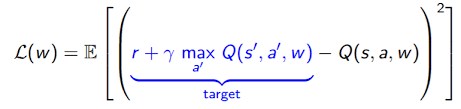

DQN is the neural network model that inputs a state and outputs Q-values for each action.\
It represents how the neural network updates the weights based on the difference between the target Q-value and the predicted Q-value.


In [13]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.output = nn.Linear(256, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.output(x)

## Developing RL Agent
We define the Agent class as the RL Agent as shown below.


We sampled a random batch of past experiences to break the correlation between consecutive experiences.

Next we calculate the Target Q-Value if episode is not done:

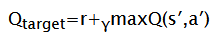

If it is done, it would be:

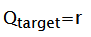

In [14]:
class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=50000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.00025

        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        with torch.no_grad():
            return torch.argmax(self.model(state)).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item()

            target_f = self.model(state)
            target_val = target_f.clone()
            target_val[action] = target

            self.optimizer.zero_grad()
            loss = self.loss_fn(target_f, target_val)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Task 1 Sampling a random state from the cart pole environment
We can see the observation and chosen action below:

In [15]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)

state = env.reset()[0]
action = agent.act(state)
print("Random State:", state)
print("Chosen Action:", action)


Random State: [-0.04543255 -0.02044139 -0.02464226 -0.02700015]
Chosen Action: 1


# Task 2: Demonstrate the effectiveness of the RL agent.

We make the agent play 1000 episodes in the environment.\
It selects the actions, receives rewards, and stores the experiences in the memory.\
After each episode, it logs progress and updates the epilson\
When there are enough experiences collected, the agent will train itself using experience replay.

In [16]:
EPISODES = 1000
batch_size = 64
rewards_list = []

for e in range(EPISODES):
    state = env.reset()[0]
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    rewards_list.append(total_reward)

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    if e % 5 == 0:
        agent.update_target_model()

    print(f"Episode: {e+1}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")

        

Episode: 1, Score: 14.0, Epsilon: 1.00
Episode: 2, Score: 21.0, Epsilon: 1.00
Episode: 3, Score: 18.0, Epsilon: 1.00
Episode: 4, Score: 33.0, Epsilon: 0.99
Episode: 5, Score: 45.0, Epsilon: 0.99


C:\Users\Ram\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 6, Score: 17.0, Epsilon: 0.99
Episode: 7, Score: 32.0, Epsilon: 0.98
Episode: 8, Score: 18.0, Epsilon: 0.98
Episode: 9, Score: 13.0, Epsilon: 0.97
Episode: 10, Score: 24.0, Epsilon: 0.97
Episode: 11, Score: 19.0, Epsilon: 0.96
Episode: 12, Score: 11.0, Epsilon: 0.96
Episode: 13, Score: 20.0, Epsilon: 0.95
Episode: 14, Score: 12.0, Epsilon: 0.95
Episode: 15, Score: 47.0, Epsilon: 0.94
Episode: 16, Score: 20.0, Epsilon: 0.94
Episode: 17, Score: 24.0, Epsilon: 0.93
Episode: 18, Score: 27.0, Epsilon: 0.93
Episode: 19, Score: 37.0, Epsilon: 0.92
Episode: 20, Score: 21.0, Epsilon: 0.92
Episode: 21, Score: 18.0, Epsilon: 0.91
Episode: 22, Score: 13.0, Epsilon: 0.91
Episode: 23, Score: 39.0, Epsilon: 0.90
Episode: 24, Score: 20.0, Epsilon: 0.90
Episode: 25, Score: 20.0, Epsilon: 0.90
Episode: 26, Score: 16.0, Epsilon: 0.89
Episode: 27, Score: 12.0, Epsilon: 0.89
Episode: 28, Score: 24.0, Epsilon: 0.88
Episode: 29, Score: 16.0, Epsilon: 0.88
Episode: 30, Score: 15.0, Epsilon: 0.87
Epis

Average Reward over 1000 episodes: 454.18
Is my agent good enough? True


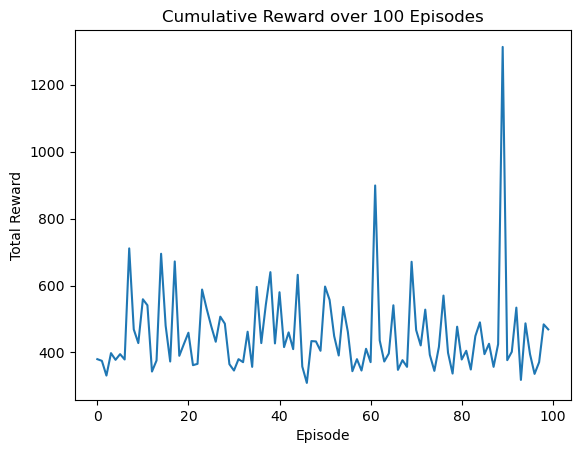

In [17]:
test_rewards = []
for _ in range(100):
    state = env.reset()[0]
    total_reward = 0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        total_reward += reward
    test_rewards.append(total_reward)

average_reward = np.mean(test_rewards)
print("Average Reward over 1000 episodes:", average_reward)
print("Is my agent good enough?", average_reward > 195)

plt.plot(test_rewards)
plt.title("Cumulative Reward over 100 Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()


# Task 3 Rendering one episode played by the developed RL agent on Jupyter. 

In [19]:
# Create a new environment for rendering
render_env = gym.make("CartPole-v1", render_mode="human")

# Reset environment and get the initial state
state = render_env.reset()[0]
done = False
total_reward = 0

while not done:
    render_env.render()  # Render the environment
    action = agent.act(state)  # Choose action from the trained agent
    next_state, reward, done, _, _ = render_env.step(action)
    state = next_state
    total_reward += reward

# Close the environment after rendering
render_env.close()

print(f"Total reward for the rendered episode: {total_reward}")

Total reward for the rendered episode: 524.0


## Conclusion

We conclude that the DQN agent performs better for solving the CartPole environment compared to the traditional Q-learning approach.

While Q-learning can work for discretized, small-scale problems, it struggles with the precision and generalization required in continuous state spaces. CartPole, though relatively simple, has a continuous state space that benefits from the function approximation and experience replay used in DQN.

DQN learns more stable and scalable policies, allowing the agent to generalize better and perform consistently well over time. With proper tuning and sufficient training episodes, DQN is able to surpass the average reward threshold of 195, making it more suitable for CartPole in both performance and future extensibility.
